### Get Book Title and Plot  

In [1]:
from threading import Thread

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wikipediaapi
import wptools

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
import string  

import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
book = pd.read_csv('book_names.csv')
book = book['name']

In [3]:
wiki_wiki = wikipediaapi.Wikipedia('en')
def get_plot(bookname, firstSection=True):
    try:
        if firstSection :
            p = wiki_wiki.page(bookname)
            sections = p.sections
            s = sections[0]
            return [s.title, s.text]
        else:
            p = wiki_wiki.page(bookname)
            sections = p.sections
            titles = []
            texts = []
            for s in sections:
                titles.append(s.title)
                texts.append(s.text)
            return dict(zip(titles, texts))  
    except:
        pass

def get_wiki(books, book_dict=None, firstSection=True):
    if book_dict is None:
        book_dict = {}
    for i in books:
        book_dict[i] = get_plot(i,firstSection)
    return book_dict

In [4]:
# thread process
def threaded_process(books,nthreads, firstSection=True):
    book_dict = {}
    threads = []
    for i in range(nthreads):
        b = books[i::nthreads]
        t = Thread(target = get_wiki, args =(b,book_dict,firstSection))
        threads.append(t)
    
    # start the threads
    [ t.start() for t in threads ]
    # wait for the threads to finish
    [ t.join() for t in threads ]
    return book_dict

In [5]:
print('Currently, there are %.0f books in the list.' % (len(book)))

Currently, there are 35991 books in the list.


In [6]:
bookdf = threaded_process(book,100) 
bookdf = pd.DataFrame.from_dict(bookdf).T
bookdf.columns = ['section', 'content']
bookdf.head(3)

,section,content
Mary Beaumont (author),Life,"Beaumont was from Halifax in Yorkshire, Englan..."
The Nameless One (novel),Books,
India's Most Attractive Brands,None,None


Check how many books that we didn't get their wiki page successfully, and try to scrape the page again.

In [7]:
bookdf.isnull().sum(axis=0)

section    20602
content    20602
dtype: int64

Now let's give it another try to scrape those missing wiki pages.

In [8]:
k = bookdf.isnull().sum(axis=0)[0]
data = bookdf.dropna(how='any')
while k > 3000:
    invalid = list(bookdf[bookdf["content"].isnull()].index)
    bookdf = threaded_process(invalid,20) 
    bookdf = pd.DataFrame.from_dict(bookdf).T
    bookdf.columns = ['section', 'content']
    k = bookdf.isnull().sum(axis=0)[0]
    print('We currently have %.0f missing records in total.' % k)
    
    data = data.append(bookdf.dropna(how='any'))

We currently have 9928 missing records in total.
We currently have 6463 missing records in total.
We currently have 4780 missing records in total.
We currently have 3703 missing records in total.
We currently have 3042 missing records in total.
We currently have 2952 missing records in total.


In [14]:
data, bookdf = temp1, temp2

In [39]:
data2 = get_wiki(list(bookdf.index))
data2 = pd.DataFrame.from_dict(data2).T
data2.columns = ['section', 'content']
data2.isnull().sum(axis=0)[0]

2793

In [40]:
data = data.append(data2.dropna(how='any'))
data = data.drop_duplicates() 

In [44]:
print('There are %.0f books.' %len(book))
print('%.0f books are available.' %len(data))
print('There are %.0f missing records.' %(len(book)-len(data)))

There are 35991 books.
30399 books are available.
There are 5592 missing records.


### Determine if the first section is the plot and do further exploration

In [45]:
names = data['section'].unique()
data.section.value_counts()[:50]

Plot summary           5977
Plot                   4677
Contents               2193
Synopsis               1734
Background             1412
Summary                1387
Plot introduction      1211
Reception               770
Overview                755
See also                658
External links          470
Content                 380
References              326
History                 324
Characters              260
Publication history     222
Description             218
Publication             166
Plot synopsis           162
Setting                 154
Stories                 142
Reviews                 136
Awards                  129
Title                   126
Editions                112
Story                    97
Critical reception       97
Themes                   91
Author                   77
Structure                76
Development              71
Origins                  71
Context                  69
Story outline            69
Adaptations              63
Premise             

We can categorize those sections into three types,
- Type one, the first section is plot. For example, when the section title is Plot Summary, Synopsis. 
- Type two, the first section is background of a book, which implies the plot might follow it and be the second or third section of a wiki page, so we need to explore the whole wiki page instead of only the first section.
- Type three, the plot is skipped, for example, when the first section title is References, Reception.

###### Type One

In [47]:
# Type one
plots = ['Plot summary','Plot', 'Contents', 'Synopsis', 'Summary', 'Plot introduction',\
         'Overview', 'Content', 'Description', 'Plot synopsis ', 'Stories', 'Context', 'Plot outline', \
         'Story outline', 'Plot Summary', 'Plot overview','Chapters', 'Story', 'Book']

print('Type one account for %.2f %% of the entire dataset.' % (100*len(data[data.section.isin(plots)])/len(data)))


Type one account for 62.90 % of the entire dataset.


Let's save this part into a clean dataset.

In [48]:
df = data[data.section.isin(plots)].reset_index()
df = df.drop('section', 1) 
df.columns = ['Title', 'Plot']

##### Type Two

In [49]:
special = ['Background', 'History', 'Characters', 'Setting','Title', 'Development', \
           'Structure',  'Introduction', 'Inspiration']

print('Books in type two account for %.0f%% of the entire dataset' % (100*len(data[data.section.isin(special)])/len(data)))

Books in type two account for 8% of the entire dataset


Here we scrape the whole page of these books and get plot sections.

In [51]:
specialwiki = list(data[data.section.isin(special)].index)
specialbook = threaded_process(specialwiki, 100, firstSection=False)
specialbook =  pd.DataFrame(specialbook.items()) 

special_book_name = []
special_book_plot = []
for i in range(len(specialbook)):
    if specialbook.iloc[i,1]:
        for k,v in specialbook.iloc[i,1].items():
            if k in plots and len(v)>0:
                special_book_name.append(specialbook.iloc[i,0])
                special_book_plot.append(v)
                continue

In [52]:
special_df= pd.DataFrame(
    {'Title': special_book_name,
     'Plot': special_book_plot,
    }) 

In [53]:
len(special_df)

960

In [54]:
df = df.append(special_df).reset_index().drop('index',1)

In [57]:
print('Among %.0f books, only %.0f books have plot in its wiki pages, they account for %.2f %%.' % \
      (len(book),len(df),100*len(df)/len(book)))

Among 35991 books, only 20080 books have plot in its wiki pages, they account for 55.79 %.


In [58]:
df.head(5)

,Title,Plot
0,The Day of the Pelican,The story follows a fictional family named the...
1,The Lost World of British Communism,The book is composed of a series of essays tha...
2,Village of Secrets,The book is a narrative regarding the role of ...
3,Gods Without Men,"Although there are many other settings, both g..."
4,The Women of the Cousins' War,The book consists of an introduction by Gregor...


In [59]:
df.to_csv('plot.csv', index=False)

If we want to get the infobox of a wiki page, run the code below. The infobox includes author, language, country, genre, etc.

In [ ]:
## get infobox, do this later
import wptools
for i in range(1):
    try:
        parse = wptools.page(books[i]).get_parse()
        infobox = parse.data.get('infobox', None)
        if infobox:
            author.append(infobox.get('author', None))
            country.append(infobox.get('country', None))
            language.append(infobox.get('language', None))
            genre.append(infobox.get('genre', None))
        else:
            author.append(None)
            country.append(None)
            language.append(None)
            genre.append(None)
            
    except:
        pass

### Clean Data

#### Cleaning Book Names
Some books have (novel) or (book) after the name.

In [3]:
df = pd.read_csv('plot.csv',index_col=False)

In [60]:
for i in range(len(df)):
    if '(' in df['Title'][i]:
        df['Title'][i] = re.sub(r'\(.*?\)', '', df['Title'][i]).strip()

#### Dealing With the Plot Length Distribution

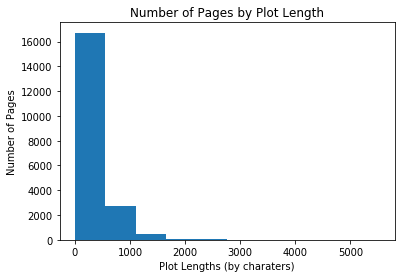

In [61]:
df['length'] = df.Plot.apply(lambda i:len(i.split(' ')))

plt.hist(df['length'])
plt.title('Number of Pages by Plot Length')
plt.xlabel("Plot Lengths (by charaters)")
plt.ylabel("Number of Pages")
plt.show()

In [62]:
print('There are %.2f%% of plots with more than 2000 characters.' % (100*len(df[df.length>=2000])/len(df)))
print('There are %.2f%% of plots with less than 40 characters.' % (100*len(df[df.length<=40])/len(df)))

There are 0.39% of plots with more than 2000 characters.
There are 9.41% of plots with less than 40 characters.


Obviously we do not need the plots with too few words. LDA is not going to assign meaningful topics when the only words to derive topics. So we are going to remove outliers and plots with too few or too many words.

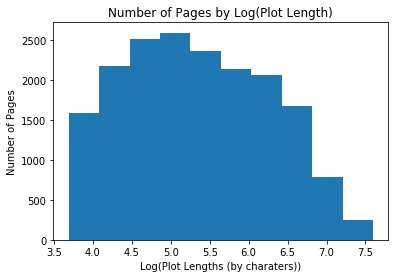

In [63]:
df = df[(df.length<=2000) & (df.length>=40)].reset_index().drop('index',axis=1)

plt.hist(np.log(df['length']))
plt.title('Number of Pages by Log(Plot Length)')
plt.xlabel("Log(Plot Lengths (by charaters))")
plt.ylabel("Number of Pages")
plt.show()

In [64]:
print('Now we have %.0f book pages.' % len(df))

Now we have 18177 book pages.


In [65]:
df = df.drop('length',axis=1)

#### Text Cleanup

Before we switch over to the tokenized articles, we should switch all articles to one line bodies, remove real expression references, remove those parts of the text that are used to distinguish between parts of an article, remove possessives, remove websites, and finally reduce all spaces in the articles to single spaces such that post cleaning we'll have a readable body.

In [66]:
def text_one_liner(book_data):
    for x in range(len(book_data)):
        book_data.loc[x,'Plot'] = book_data.loc[x,'Plot'].replace('\n', '')
    return book_data

df_clean = text_one_liner(df)

In [67]:
def real_exp_remover(book_data):
    for x in range(len(book_data)):
        book_data.loc[x,'Plot'] = re.sub(r'\(.*?\)', '', book_data.loc[x,'Plot'])
        book_data.loc[x,'Plot'] = re.sub(r'\<.*?\>', '', book_data.loc[x,'Plot'])
        book_data.loc[x,'Plot'] = re.sub(r'\[.*?\]', '', book_data.loc[x,'Plot'])
        book_data.loc[x,'Plot'] = re.sub(r'\==.*?\==', '', book_data.loc[x,'Plot'])
    return book_data

df_clean = real_exp_remover(df_clean)

In [68]:
def possessive_fixer(book_data):
    for x in range(len(book_data)):
        book_data.loc[x,'Plot'] = book_data.loc[x,'Plot'].replace("\'", "")
    return book_data

df_clean = possessive_fixer(df_clean)

In [69]:
def website_remover(book_data):
    for x in range(len(book_data)):
        websites = []
        for word in book_data.loc[x,'Plot'].split(' '):
            if word[:4] == 'http':
                websites.append(word)
        
        for website in websites:
            book_data.loc[x,'Plot'] = book_data.loc[x,'Plot'].replace(website, '')
    return book_data

df_clean = website_remover(df_clean)

In [70]:
def space_reducer(book_data):
    for x in range(len(book_data)):
        for i in range(10, 0, -1): #Loop backwards to assure that smaller spaces aren't made by larger deletions and then missed
            large_space = str(i*' ')
            if large_space in book_data.loc[x,'Plot']:
                book_data.loc[x,'Plot'] = book_data.loc[x,'Plot'].replace(large_space, ' ')
    return book_data

df_clean = website_remover(df_clean)

In [73]:
# tokenization, remove punctuation, normalize case, remove stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 
def punctuation_stopWords_remover_lemma(book_data):
    res = []
    for x in range(len(book_data)):
        tokens = word_tokenize(book_data.loc[x,'Plot'])
        table = str.maketrans('', '', string.punctuation)
        words = [w.translate(table).lower() for w in tokens if w.isalpha()]
        words = [lemmatizer.lemmatize(w) for w in words if not w in stop_words]
        res.append(words)
    return res

tokens = punctuation_stopWords_remover_lemma(df_clean)
df_clean['tokens'] = tokens

In [74]:
df_clean.head()

,Title,Plot,tokens
0,The Day of the Pelican,The story follows a fictional family named the...,"[story, follows, fictional, family, named, lle..."
1,The Lost World of British Communism,The book is composed of a series of essays tha...,"[book, composed, series, essay, collected, tog..."
2,Village of Secrets,The book is a narrative regarding the role of ...,"[book, narrative, regarding, role, resident, f..."
3,Gods Without Men,"Although there are many other settings, both g...","[although, many, setting, geographically, temp..."
4,The Women of the Cousins' War,The book consists of an introduction by Gregor...,"[book, consists, introduction, gregory, three,..."


In [75]:
df_clean.to_csv('clean_data.csv',index=False)

### Data Exploration

In [76]:
## custom function for ngram generation ##
def generate_ngrams(token, n_gram=1):
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [77]:
### One Word
from collections import defaultdict

def plot_frequent_words(n_gram):
    freq_dict = defaultdict(int)

    for q in df['tokens']:
        for word in generate_ngrams(q,n_gram):
            freq_dict[word] += 1

    plot_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x:x[1], reverse=True))[0:20]
    plot_sorted.columns = ["word", "wordcount"]

    plt.barh(plot_sorted.word[::-1], plot_sorted.wordcount[::-1])
    plt.title('Frequent Words -'+str(n_gram)+' Word')

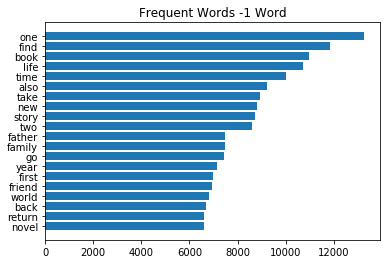

In [78]:
plot_frequent_words(1)

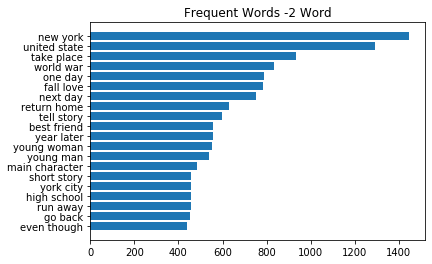

In [79]:
plot_frequent_words(2)

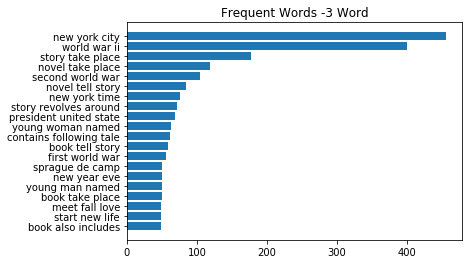

In [80]:
plot_frequent_words(3)